In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import re
import pickle as pk

In [3]:
path =  'd:/Git_Proyects/Tesis/Faiss_vect/'
citas = pk.load(open(path+'cita_media_cluster_august.pk', 'rb'))

In [35]:
index = 10
df_clus_completo = pd.read_csv(path+f'Tw_mas_RT/RT_Tw_cluster_{index}.csv')
df_clus_completo['Fecha'] = pd.to_datetime(df_clus_completo['Fecha'], format='%a %b %d %H:%M:%S +0000 %Y')
df_clus_completo['HorasDesdeInicio'] = (df_clus_completo['Fecha'] - df_clus_completo['Fecha'].min()).dt.total_seconds() / 3600

categoria = 'RT'

df_categoria_true = df_clus_completo[df_clus_completo[categoria] == True]
df_categoria_false = df_clus_completo[df_clus_completo[categoria] == False]

df_categoria = [df_categoria_true, df_categoria_false]
labels = ['RT', 'Tw originales']

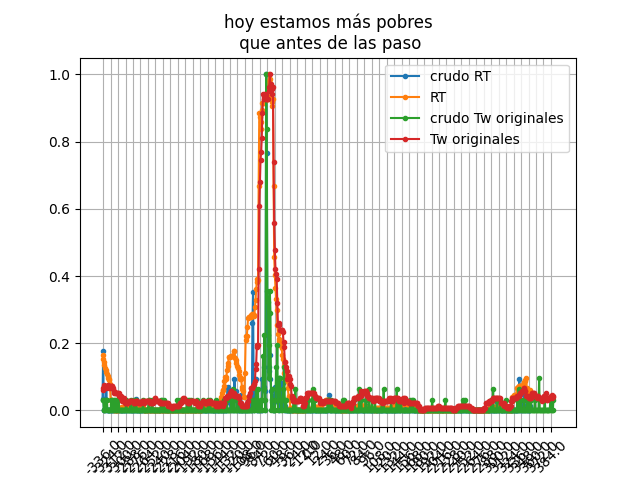

In [5]:
%matplotlib widget
plt.figure()
firstpart, secondpart = citas[index][:len(citas[index])//2], citas[index][len(citas[index])//2:]
plt.title(firstpart+'\n'+secondpart)
for i, df1 in enumerate(df_categoria):
    df = df1.copy()
    df_index = df.set_index('Fecha')
    df_count_hora = df_index.resample('1H').count()
    plt.plot(df_count_hora.index, df_count_hora['Tweets']/max(df_count_hora['Tweets']), label = 'crudo '+str(labels[i]), marker = '.') #Test comparation
    #plt.plot(df_count_hora.index, df_count_hora['Tweets'], label = 'crudo '+str(labels[i]), marker = '.') 
    df_suavizado = df_count_hora.rolling('1D', center = True).mean()
    df_suavizado_2 = df_count_hora.ewm( alpha = 0.1).mean()

    plt.plot(df_suavizado.index, df_suavizado['Tweets']/max(df_suavizado['Tweets']), label = labels[i], marker = '.', linestyle = 'solid')
    #plt.plot(df_suavizado_2.index, df_suavizado_2['Tweets'], label = 'filltro ewp', marker = '.', linestyle = 'solid', color = 'k')

plt.xticks(pd.date_range(start=df_clus_completo['Fecha'].min(), end=df_clus_completo['Fecha'].max(), freq='12H')
           , labels= (np.arange(df_clus_completo['HorasDesdeInicio'].min(), df_clus_completo['HorasDesdeInicio'].max(), 12)-336))
plt.legend()
plt.grid(0.7)
plt.xticks(rotation=45)
plt.show()

In [34]:
citas[313]

'que no vaya a creer que lo eligieron porque es él'